## Setup

In [374]:
# Import necessary libraries
import os
import random
import numpy as np
from tqdm import trange
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from typing import Callable, Optional, Tuple, Union, List
from IPython.display import Image, display

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler


from sklearn.datasets import make_moons, make_circles

In [375]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using mps device


In [376]:
# @title visualization helpers

def visualize(flow, epoch, output_dir='frames', device='cpu'):
    # Create directory for saving frames
    os.makedirs(output_dir, exist_ok=True)

    # Visualization of the learned density
    with torch.no_grad():
        # Create a grid over the range of the data
        xline = torch.linspace(-2, 3, 300, device=device)
        yline = torch.linspace(-1, 1.5, 300, device=device)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
        xyinput = torch.cat([xgrid.reshape(-1, 1),
                             ygrid.reshape(-1, 1)], dim=1).to(device)

        # Compute the log probability for each point in the grid
        log_prob_grid = flow.log_prob(xyinput)  # Compute log probs
        zgrid = torch.exp(log_prob_grid).reshape(300, 300).cpu()  # Convert to probability

        # Plot the density
        plt.figure(figsize=(8, 6))
        plt.contourf(
            xgrid.cpu().numpy(),
            ygrid.cpu().numpy(),
            zgrid.numpy(),
            levels=50,
            cmap='viridis'
        )
        plt.title(f'Learned Density at Epoch {epoch}')
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.colorbar(label='Density')

        # Save frame as an image
        filename = os.path.join(output_dir, f'frame_{epoch:03d}.png')
        plt.savefig(filename)
        plt.close()

def create_gif(output_dir='frames', gif_name='density_evolution.gif', fps=10):
    images = []
    for frame in sorted(os.listdir(output_dir)):
        if frame.endswith(".png"):
            images.append(imageio.imread(os.path.join(output_dir, frame)))
    imageio.mimsave(gif_name, images, fps=fps)
    display(Image(filename=gif_name))
    return gif_name

In [377]:
X, y = make_moons(n_samples=10000, noise=0.1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)

dataset = TensorDataset(X)
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)


In [343]:
class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise 'InverseNotAvailable'

In [370]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

In [378]:
class CouplingTransform(Transform):
    def __init__(self, mask, num_features, hidden_dims):
        super().__init__()
        self.mask = torch.tensor(mask, dtype=torch.float32)
        self.scale_net = self._initialize_network(num_features, hidden_dims)
        self.shift_net = self._initialize_network(num_features, hidden_dims)

    def _initialize_network(self, num_features, hidden_dims):
        return nn.Sequential(
            nn.Linear(num_features, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, num_features),
            nn.Hardtanh(min_val=-5, max_val=5)
        )

    def forward(self, inputs, context=None):
        x_masked = inputs * self.mask
        scale = self.scale_net(x_masked) * (1 - self.mask)
        shift = self.shift_net(x_masked) * (1 - self.mask)
        z = x_masked + (1 - self.mask) * (inputs * torch.exp(scale) + shift)
        log_det_jacobian = torch.sum(scale * (1 - self.mask), dim=1)
        return z, log_det_jacobian

    def inverse(self, z, context=None):
        z_masked = z * self.mask
        scale = self.scale_net(z_masked) * (1 - self.mask)
        shift = self.shift_net(z_masked) * (1 - self.mask)
        x = z_masked + (1 - self.mask) * (z - shift) * torch.exp(-scale)
        return x


# Flows 

In [379]:
class Flow(nn.Module):
    def __init__(self, transforms, num_features):
        super().__init__()
        self.transforms = nn.ModuleList(transforms)
        self.base_distribution = MultivariateNormal(
            loc=torch.zeros(num_features), covariance_matrix=torch.eye(num_features)
        )

    def forward(self, x):
        log_det_jacobian = 0
        for transform in self.transforms:
            x, log_det = transform(x)
            log_det_jacobian += log_det
        return x, log_det_jacobian

    def inverse(self, z):
        for transform in reversed(self.transforms):
            z = transform.inverse(z)
        return z

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        base_log_prob = self.base_distribution.log_prob(z)
        return base_log_prob + log_det_jacobian

    def sample(self, num_samples):
        z = self.base_distribution.sample((num_samples,))
        return self.inverse(z)


# Masks 

In [ ]:
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [(j + i) % 2 for j in range(num_features)]
        masks.append(mask)
    return masks

# Training 

In [401]:
def train_and_visualize(data_loader, flow, optimizer, num_epochs=50, num_samples=500, device="cpu"):
    flow.to(device)
    loss_history = []
    output_dir = 'frames'
    os.makedirs(output_dir, exist_ok=True)

    selected_epochs = set(
        np.linspace(0, num_epochs - 1, 10, dtype=int)
    )  # Select 10 equally spaced epochs

    for epoch in range(num_epochs):
        flow.train()
        total_loss = 0

        for batch in data_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            log_prob = flow.log_prob(batch)
            loss = -log_prob.mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(data_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

        flow.eval()
        with torch.no_grad():
            if epoch in selected_epochs:
                samples = flow.sample(num_samples).cpu()
                plt.figure(figsize=(6, 6))
                plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label=f"Generated Epoch {epoch + 1}")
                plt.xlim(-2, 3)
                plt.ylim(-1.5, 2)
                plt.title(f"Generated Samples at Epoch {epoch + 1}")
                plt.xlabel(r"$x_1$")
                plt.ylabel(r"$x_2$")
                plt.legend()
                plt.grid(True)
                #plt.savefig(f"{output_dir}/samples_epoch_{epoch + 1}.png")
                plt.close()

            visualize(flow, epoch + 1, output_dir=output_dir, device=device)

    create_gif(output_dir=output_dir, gif_name="density_evolution.gif", fps=10)
    print("GIF created: density_evolution.gif")

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs + 1), loss_history, marker="o", label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch [1/10], Loss: 2.5982
Epoch [2/10], Loss: 2.4654
Epoch [3/10], Loss: 2.3079
Epoch [4/10], Loss: 2.1945
Epoch [5/10], Loss: 2.1275
Epoch [6/10], Loss: 2.0830
Epoch [7/10], Loss: 2.0751
Epoch [8/10], Loss: 1.9608
Epoch [9/10], Loss: 1.9738
Epoch [10/10], Loss: 1.9317


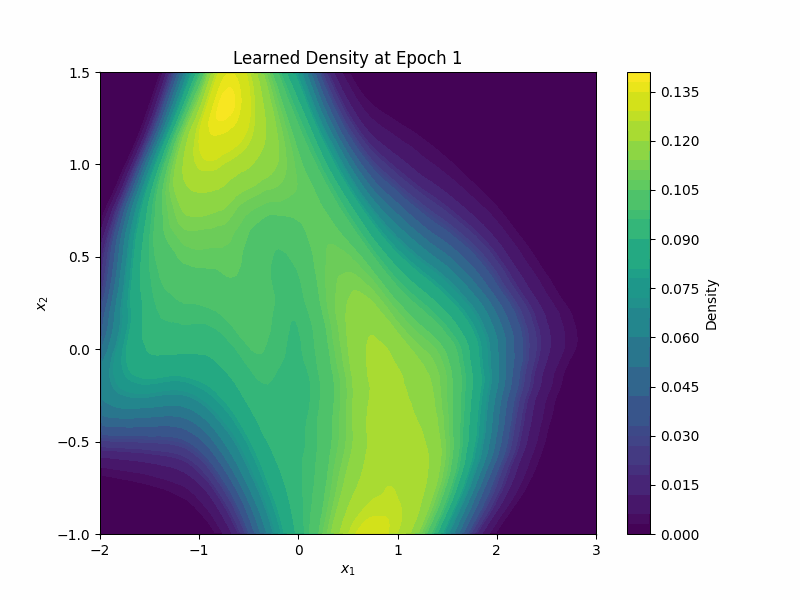

GIF created: density_evolution.gif


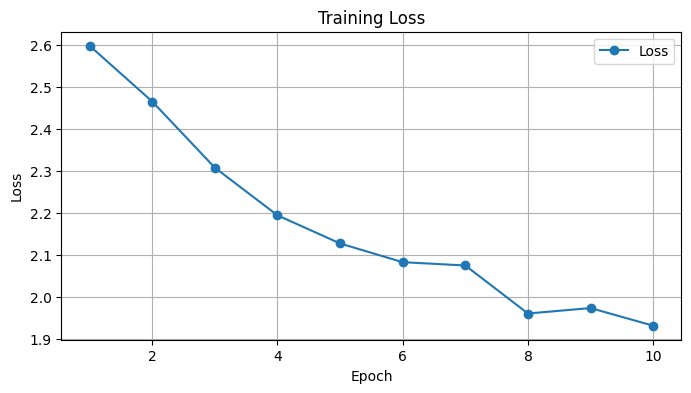

In [402]:
num_features = 2
num_masks = 16
hidden_dims = 64
num_epochs = 10
num_samples = 500

masks = create_alternating_masks(num_features, num_masks)
transforms = [CouplingTransform(mask, num_features, hidden_dims) for mask in masks]
flow = Flow(transforms, num_features)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

train_and_visualize(data_loader, flow, optimizer, num_epochs=num_epochs)

# Visualizations 

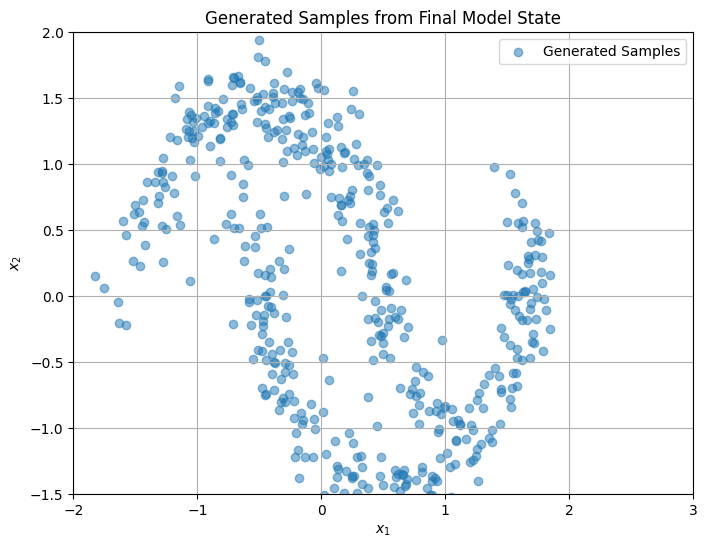

In [404]:
flow.eval()
with torch.no_grad():
    samples = flow.sample(num_samples=500).cpu()

    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Generated Samples")
    plt.title("Generated Samples from Final Model State")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.legend()
    plt.grid(True)
    plt.xlim(-2, 3)
    plt.ylim(-1.5, 2)
    plt.show()
